🧬 Single-Cell RNA-seq Analysis with Scanpy

This notebook walks through a complete single-cell RNA-seq (scRNA-seq) data analysis pipeline using the Python package Scanpy project. The pipeline uses Scanpy to process and analyze human bone marrow data, including:

1. Data loading and preprocessing

2. Quality control and filtering

3. Normalization and highly variable gene selection

4. PCA, neighborhood graph construction, and UMAP

5. Leiden clustering at multiple resolutions

6. Cell-type annotation using BioMart gene mapping, PanglaoDB markers, decoupler scoring, and cluster-specific marker genes

It provides a complete, reproducible record of the computational steps used to generate and interpret the final annotated cell populations.

🧩 Loading Data

The human bone marrow single-cell expression matrix is loaded into an AnnData object, the central data structure in Scanpy. This object organizes the dataset as follows:

• adata.X – the raw expression matrix (cells × genes)

• adata.obs – metadata for each cell (e.g., QC metrics, cluster assignments)

• adata.var – metadata for each gene (e.g., gene symbols, Ensembl IDs)

This structure provides the foundation for all downstream analysis steps, from QC and normalization to clustering and cell-type annotation.

In [1]:
# Import single cell tools
import scanpy as sc
import anndata as ad

In [3]:
# Load bone marrow dataset
file_path = r"C:\Users\User\Desktop\bone_marrow.h5ad"
bone_marrow_adata = sc.read_h5ad(file_path)
bone_marrow_adata


AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [4]:
# the dimensions of the dataset
bone_marrow_adata.shape

(14783, 17374)

In [5]:
# the number of cells in the dataset: 14783
# the number of genes in the dataset: 17374

In [6]:
# view the first 5 rows describing the genes in the dataset
bone_marrow_adata.var.head(5)

,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000161920,927,False,MED11,NCBITaxon:9606,gene,754,protein_coding
ENSG00000122335,429,False,SERAC1,NCBITaxon:9606,gene,2683,protein_coding
ENSG00000175548,149,False,ALG10B,NCBITaxon:9606,gene,1773,protein_coding
ENSG00000100330,426,False,MTMR3,NCBITaxon:9606,gene,634,protein_coding
ENSG00000176340,7171,False,COX8A,NCBITaxon:9606,gene,494,protein_coding


In [17]:
# view the first 5 rows describing the cells in the dataset
bone_marrow_adata.obs.head(5)
     

,disease stage,treatment,timepoint,Dataset,sample,disease_original,disease_general,COVID-19 Condition,Lineage,Cell.group,...,is_primary_data,suspension_type,tissue_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep2,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Myeloid,CD14+ Monocyte,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,2P)e%zgsv_
Guo-AAACCTGAGAGGTTGC-7,remission,400 mg Tocilizumab at day 1,day 7,Guo et al._Nature Communication,Guo_P2-day7,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD8+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,78-year-old stage,Lv&N1yD6*0
Guo-AAACCTGAGATACACA-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,DZ>`^5OH2o
Guo-AAACCTGAGCGATTCT-1,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep1,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Lymphoid_T/NK,CD8+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,J4$QmqEgvX
Guo-AAACCTGAGTGAAGAG-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,False,cell,tissue,10x 3' v2,COVID-19,male,blood,unknown,39-year-old stage,Y&7u#&E`-T


In [8]:
# view both in a proper dataframe format
bone_marrow_adata.to_df()
     

,ENSG00000161920,ENSG00000122335,ENSG00000175548,ENSG00000100330,ENSG00000176340,ENSG00000179846,ENSG00000204860,ENSG00000172260,ENSG00000141424,ENSG00000164512,...,ENSG00000164114,ENSG00000151702,ENSG00000224578,ENSG00000138756,ENSG00000111052,ENSG00000176946,ENSG00000150456,ENSG00000284934,ENSG00000261842,ENSG00000260456
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,0.0,0.000000,0.0,0.0,9.436466,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGAGGTTGC-7,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,8.817776,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGATACACA-3,0.0,8.651494,0.0,0.0,8.651494,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGCGATTCT-1,0.0,0.000000,0.0,0.0,8.858533,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-AAACCTGAGTGAAGAG-3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guo-TTTGTCAGTTTCGCTC-4,0.0,0.000000,0.0,0.0,8.389465,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-TTTGTCATCAGAGACG-7,0.0,0.000000,0.0,0.0,9.931639,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guo-TTTGTCATCAGATAAG-4,0.0,0.000000,0.0,0.0,10.009642,0.0,0.0,0.0,0.000000,0.0,...,0.0,9.01104,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


🧹 Quality Control (QC)

Quality control ensures that only high-quality cells and informative genes are retained for downstream analysis. In this dataset, QC includes:

• Ensuring unique gene names to avoid duplications from previous pipelines

• Filtering cells with too few detected genes, which may indicate dead or low-quality cells

• Filtering cells with abnormally high gene counts, potentially representing doublets

• Removing genes expressed in very few cells, as they provide limited biological information

These steps help maintain a clean, reliable dataset for normalization, clustering, and cell-type annotation.

In [9]:
# Make genes and cells names unique
bone_marrow_adata.var_names_make_unique()
bone_marrow_adata.obs_names_make_unique()

In [13]:
# check for possible contamination from dying cells, ribosomal transcripts or hemoglobin
# Remove cells with high mitochondrial reads (>10-20%) (stressed/dead)
# Remove ribosomal genes (non-specific transcription)
# High hemoglobin signal often comes from red blood cell contamination

bone_marrow_adata.var['MT'] = bone_marrow_adata.var['feature_name'].str.upper().str.startswith("MT-")
bone_marrow_adata.var['RIBO'] = bone_marrow_adata.var['feature_name'].str.upper().str.startswith(("RPS","RPL"))
bone_marrow_adata.var['HB'] = bone_marrow_adata.var['feature_name'].str.upper().str.startswith(("HB","HBA","HBB"))

In [14]:
# A quick look at one of them.
mt_genes = bone_marrow_adata.var[bone_marrow_adata.var['MT']]
mt_genes

,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,MT,RIBO,HB
ENSG00000228253,2270,False,MT-ATP8,NCBITaxon:9606,gene,207,protein_coding,True,False,False
ENSG00000198899,15626,False,MT-ATP6,NCBITaxon:9606,gene,681,protein_coding,True,False,False
ENSG00000198763,15561,False,MT-ND2,NCBITaxon:9606,gene,1042,protein_coding,True,False,False
ENSG00000198886,15656,False,MT-ND4,NCBITaxon:9606,gene,1378,protein_coding,True,False,False
ENSG00000198804,15656,False,MT-CO1,NCBITaxon:9606,gene,1542,protein_coding,True,False,False
ENSG00000198695,4611,False,MT-ND6,NCBITaxon:9606,gene,525,protein_coding,True,False,False
ENSG00000212907,6575,False,MT-ND4L,NCBITaxon:9606,gene,297,protein_coding,True,False,False
ENSG00000198888,14520,False,MT-ND1,NCBITaxon:9606,gene,956,protein_coding,True,False,False
ENSG00000198712,15669,False,MT-CO2,NCBITaxon:9606,gene,684,protein_coding,True,False,False
ENSG00000198727,15393,False,MT-CYB,NCBITaxon:9606,gene,1141,protein_coding,True,False,False


In [15]:
# Calculated qc metrics
sc.pp.calculate_qc_metrics(bone_marrow_adata, qc_vars=["MT", "RIBO", "HB"], inplace=True, log1p=True )

In [16]:
# qc metrics is involved in the headers of obs and var
bone_marrow_adata.obs.head()

,disease stage,treatment,timepoint,Dataset,sample,disease_original,disease_general,COVID-19 Condition,Lineage,Cell.group,...,pct_counts_in_top_500_genes,total_counts_MT,log1p_total_counts_MT,pct_counts_MT,total_counts_RIBO,log1p_total_counts_RIBO,pct_counts_RIBO,total_counts_HB,log1p_total_counts_HB,pct_counts_HB
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep2,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Myeloid,CD14+ Monocyte,...,40.537370,138.356339,4.937034,1.154665,879.968079,6.781022,7.343850,0.000000,0.000000,0.000000
Guo-AAACCTGAGAGGTTGC-7,remission,400 mg Tocilizumab at day 1,day 7,Guo et al._Nature Communication,Guo_P2-day7,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD8+ T cell,...,57.850376,113.859787,4.743712,1.350507,914.212402,6.819156,10.843602,0.000000,0.000000,0.000000
Guo-AAACCTGAGATACACA-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,59.749640,125.068520,4.836825,1.543431,952.813843,6.860468,11.758374,26.952686,3.330513,0.332615
Guo-AAACCTGAGCGATTCT-1,severe,400 mg Tocilizumab at day 1,day 1,Guo et al._Nature Communication,Guo_P1-day1-rep1,COVID-19 Severe,COVID-19 Severe/Late stage/Vent,severe,Lymphoid_T/NK,CD8+ T cell,...,56.156243,103.474380,4.648942,1.182754,924.013672,6.829809,10.561848,8.858533,2.288337,0.101257
Guo-AAACCTGAGTGAAGAG-3,remission,400 mg Tocilizumab at day 1,day 5,Guo et al._Nature Communication,Guo_P1-day5-rep1,COVID-19 Mild/Remission,COVID-19 Remission,remission,Lymphoid_T/NK,CD4+ T cell,...,100.000121,138.531082,4.938287,2.870118,850.272156,6.746732,17.616129,0.000000,0.000000,0.000000


In [17]:
bone_marrow_adata.var.head()

,n_cells,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type,MT,RIBO,HB,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSG00000161920,927,False,MED11,NCBITaxon:9606,gene,754,protein_coding,False,False,False,885,0.502831,0.407351,94.013394,7433.353516,8.913867
ENSG00000122335,429,False,SERAC1,NCBITaxon:9606,gene,2683,protein_coding,False,False,False,405,0.231814,0.208488,97.260367,3426.911377,8.139707
ENSG00000175548,149,False,ALG10B,NCBITaxon:9606,gene,1773,protein_coding,False,False,False,142,0.082084,0.078889,99.039437,1213.443970,7.102042
ENSG00000100330,426,False,MTMR3,NCBITaxon:9606,gene,634,protein_coding,False,False,False,404,0.227307,0.204822,97.267131,3360.278564,8.120077
ENSG00000176340,7171,False,COX8A,NCBITaxon:9606,gene,494,protein_coding,False,False,False,6898,4.277597,1.663471,53.338294,63235.750000,11.054641


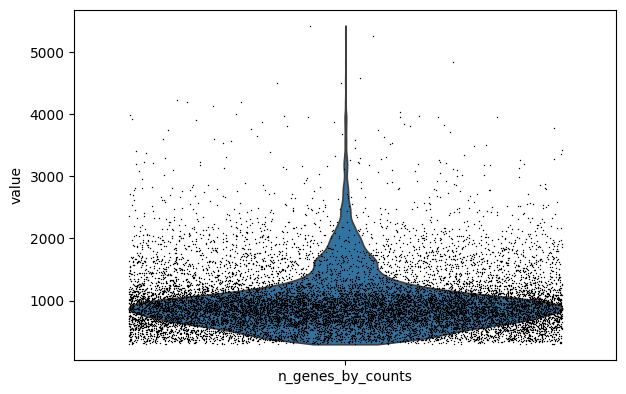

In [19]:
# Number of genes detected in each cell
sc.pl.violin(
    bone_marrow_adata,
    ['n_genes_by_counts'],
    jitter=0.4,
    multi_panel=False,
)


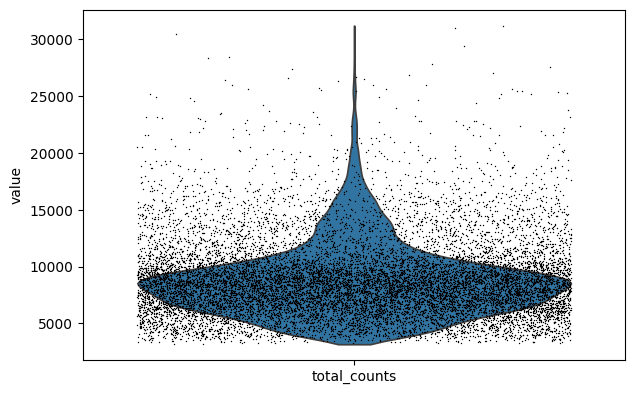

In [20]:
# The total number of molecules detected in a cell.
sc.pl.violin(
    bone_marrow_adata,
    ['total_counts'],
    jitter=0.4,
    multi_panel=False,
)

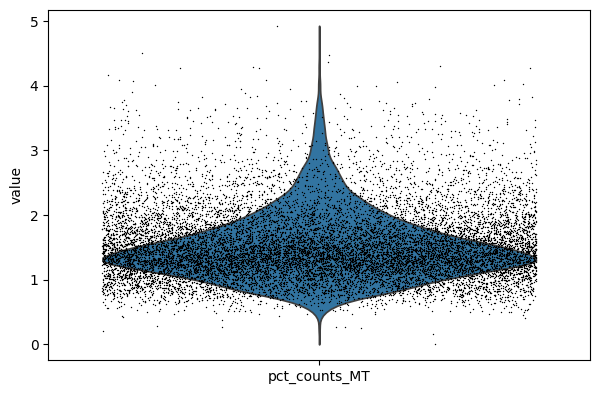

In [22]:
#  Mitochondrial genes?
sc.pl.violin(
    bone_marrow_adata,
    ["pct_counts_MT"],
    jitter=0.4,
    multi_panel=False,
)

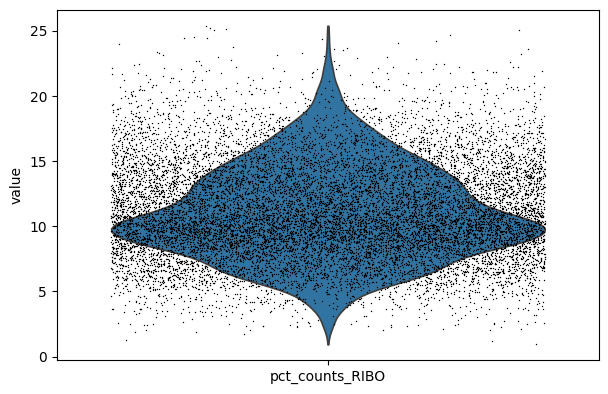

In [23]:
# Ribosomal genes
sc.pl.violin(
    bone_marrow_adata,
    ["pct_counts_RIBO"],
    jitter=0.4,
    multi_panel=False,
)

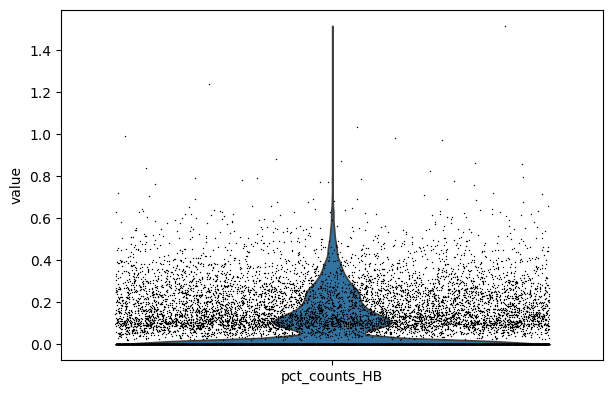

In [24]:
#  Hemoglobin genes?
sc.pl.violin(
    bone_marrow_adata,
    ["pct_counts_HB"],
    jitter=0.4,
    multi_panel=False,
)

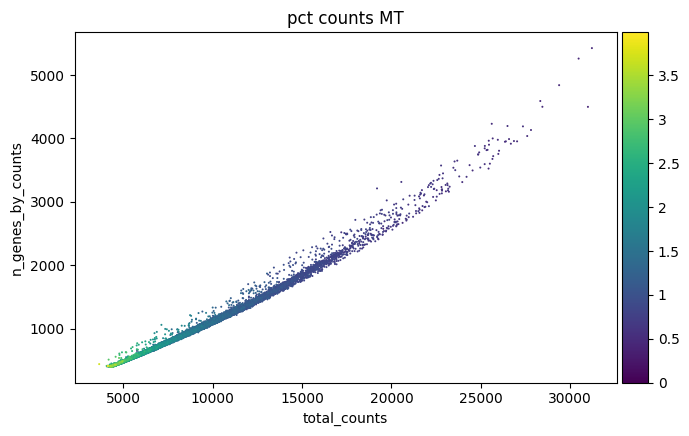

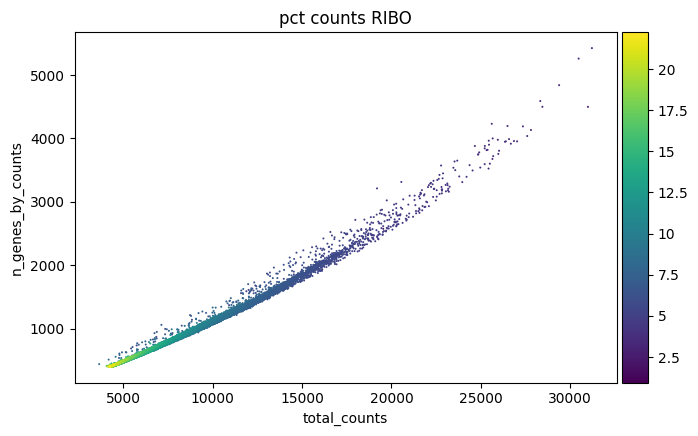

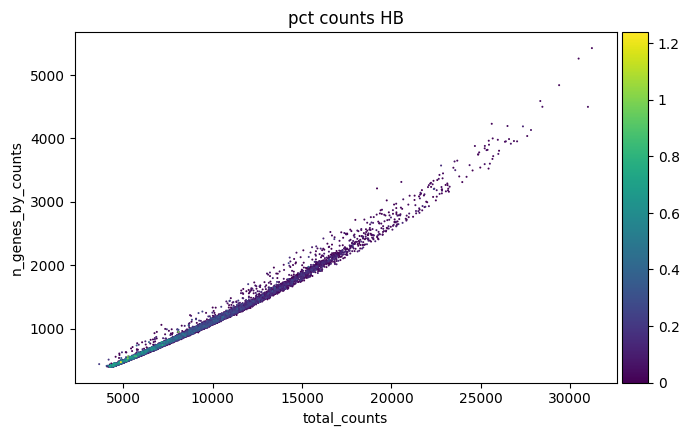

In [32]:
# Checked for stressed cells or potential doublets
sc.pl.scatter(bone_marrow_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_MT")
sc.pl.scatter(bone_marrow_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_RIBO")
sc.pl.scatter(bone_marrow_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_HB")

Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as qualitycontrol thresholds can vary substantially between batches.

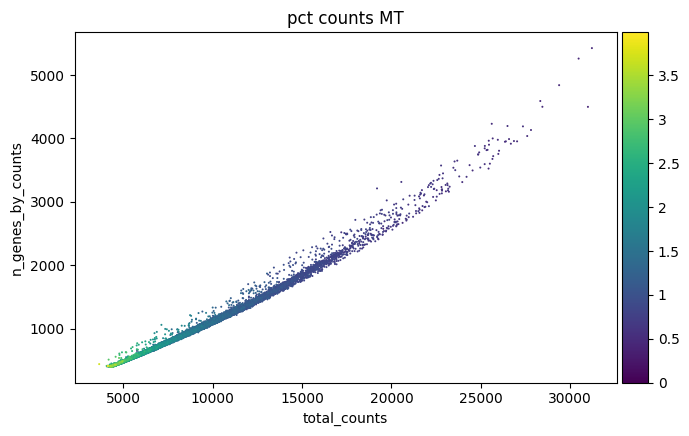

In [33]:
# filtering
sc.pp.filter_cells(bone_marrow_adata, min_genes=400)
sc.pp.filter_genes(bone_marrow_adata, min_cells=3)

# filtered stressed cells
bone_marrow_adata = bone_marrow_adata[bone_marrow_adata.obs['pct_counts_MT'] < 5]
sc.pl.scatter(bone_marrow_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_MT")

In [34]:
# doublet detection
# Identifying doublets is crucial as they can lead to misclassifications or
# distortions in downstream analysis steps

In [35]:
# Save a copy of the data
bone_marrow_adata.layers["counts"] = bone_marrow_adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(bone_marrow_adata)
# Logarithmize the data
sc.pp.log1p(bone_marrow_adata)

C:\Users\User\AppData\Local\Temp\ipykernel_24984\49816289.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  bone_marrow_adata.layers["counts"] = bone_marrow_adata.X.copy()


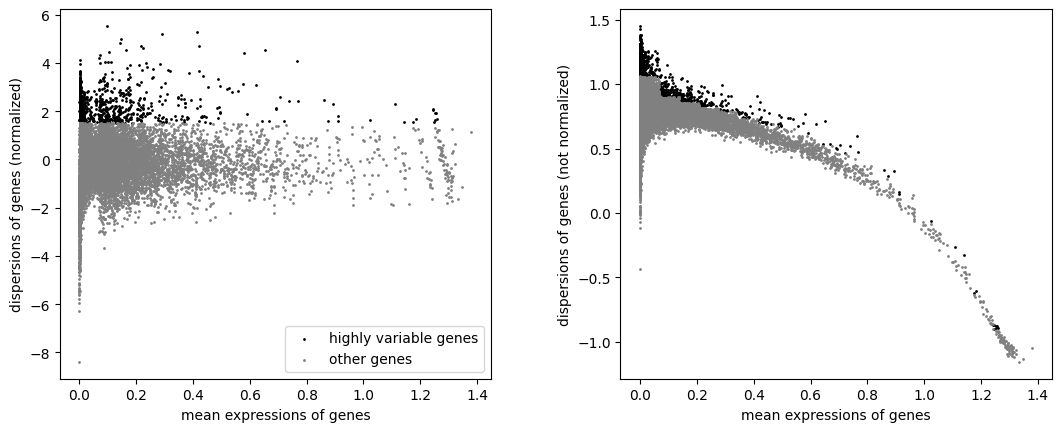

In [36]:
#Feature selection
#selecting the top 1000 most variable genes
sc.pp.highly_variable_genes(bone_marrow_adata, n_top_genes=1000)
     
sc.pl.highly_variable_genes(bone_marrow_adata)

🔍 Dimensionality Reduction (PCA)

Principal Component Analysis (PCA) is used to reduce the complexity of the single-cell expression matrix while preserving key biological variation. By compressing thousands of gene expression values into a smaller set of principal components (typically 30–50), PCA:

* Reduces noise by capturing the strongest correlated gene expression patterns

* Improves computational efficiency for downstream analyses like clustering and UMAP

* Extracts meaningful biological signals, such as cell types, cell cycle states, or activation patterns

* This step provides a robust foundation for clustering and visualization in the downstream workflow.

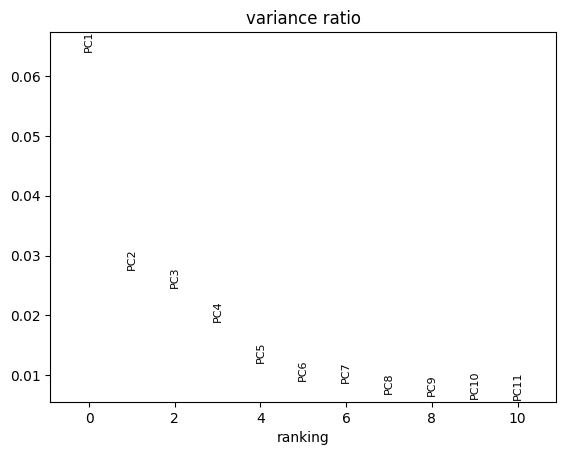

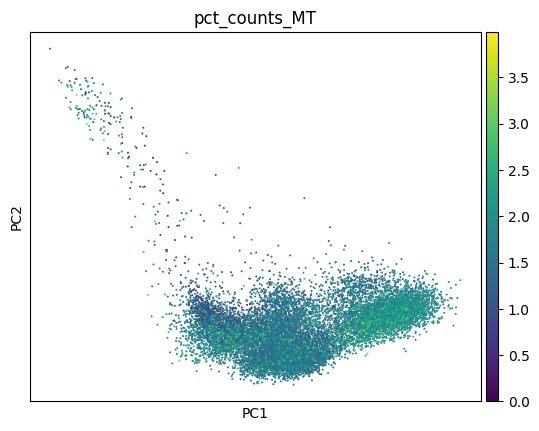

In [37]:
# Dimensionality reduction to reduce data complexity and highlight key variation patterns
sc.tl.pca(bone_marrow_adata)
sc.pl.pca_variance_ratio(bone_marrow_adata, n_pcs=10, log=False)
sc.pl.pca( bone_marrow_adata, color=["pct_counts_MT"] )

In [38]:
## Nearest Neighbour

# Compute the neighborhood graph of cells using the PCA representation of the data matrix i.e cluster the PCA components

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


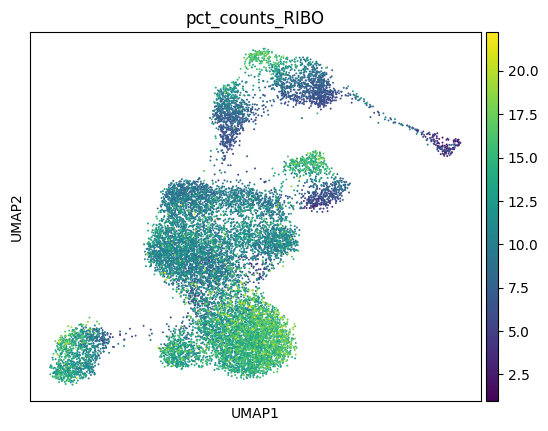

In [39]:
# Checked for the nearest neighbors
sc.pp.neighbors(bone_marrow_adata)
sc.tl.umap(bone_marrow_adata)
sc.pl.umap( bone_marrow_adata, color=["pct_counts_RIBO"], size=8, )

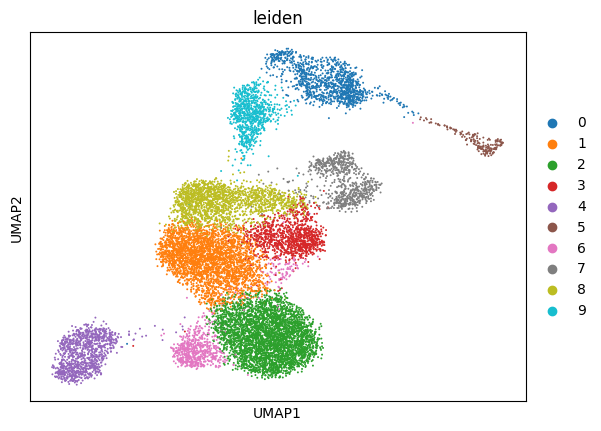

In [40]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2)
sc.pl.umap( bone_marrow_adata, color=["leiden"], size=8,)

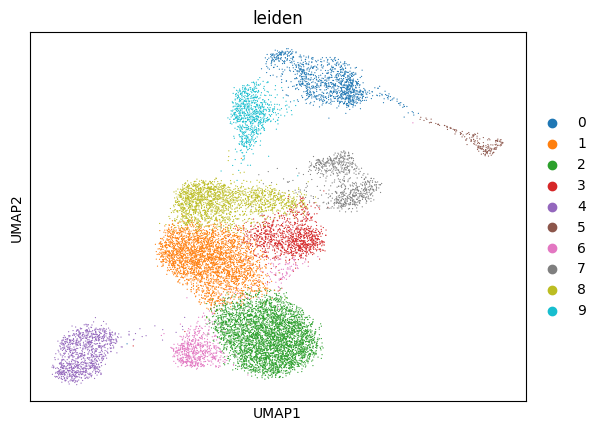

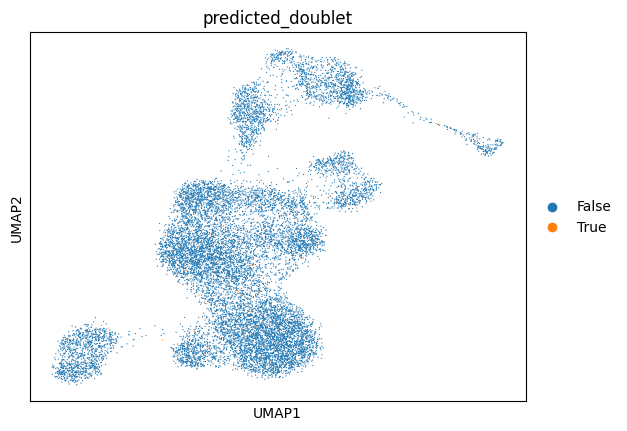

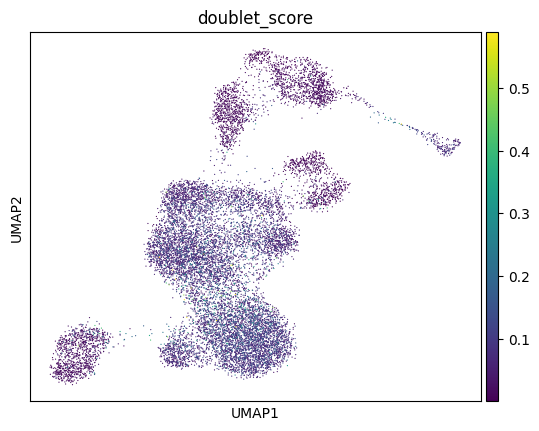

In [41]:
# Checked for the number of cells and doublets
sc.pl.umap( bone_marrow_adata, color=["leiden"], wspace=0.5, size=3, ncols = 1 )
sc.pl.umap( bone_marrow_adata, color=[ "predicted_doublet"], wspace=0.5, size=3, ncols = 1 )
sc.pl.umap( bone_marrow_adata, color=[ "doublet_score"], wspace=0.5, size=3, ncols = 1 )

In [42]:
# Further clustering at different resolutions
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_2", resolution=0.2)
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res1_0", resolution=1.0)
sc.tl.leiden(bone_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res2_0", resolution=2.0)

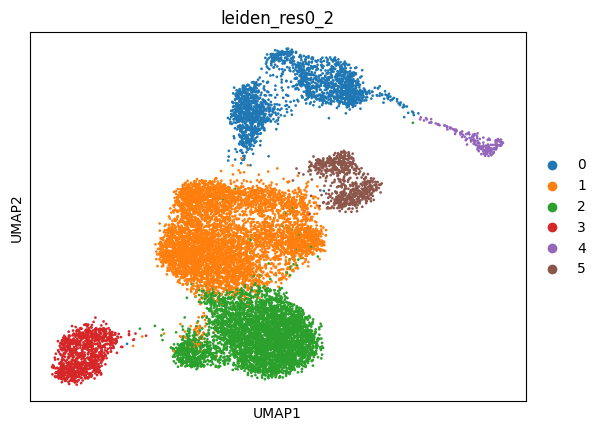

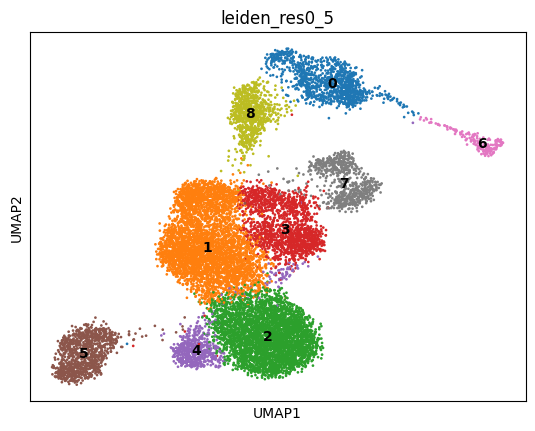

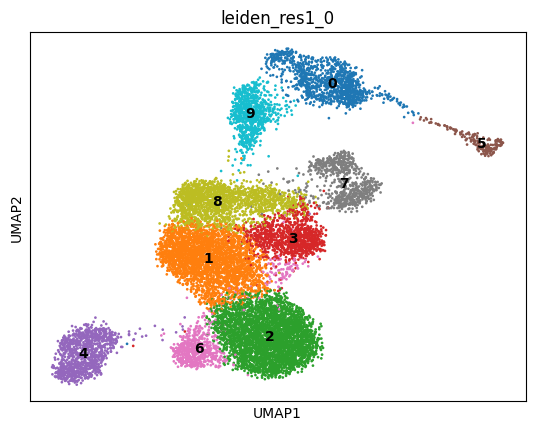

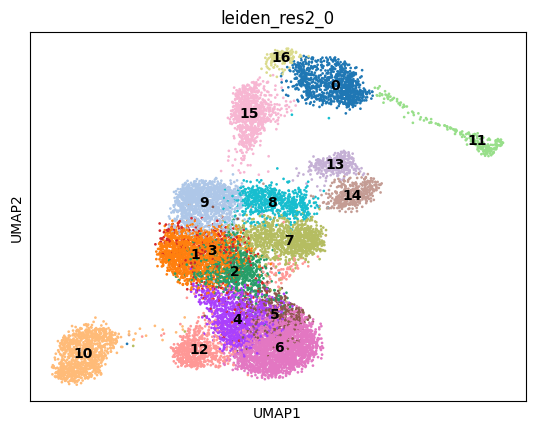

In [43]:
sc.pl.umap( bone_marrow_adata, color=["leiden_res0_2"], wspace=0.5, size=15, ncols = 1 )
sc.pl.umap( bone_marrow_adata, color=["leiden_res0_5"], wspace=0.5, size=15, ncols = 1, legend_loc="on data")
sc.pl.umap( bone_marrow_adata, color=["leiden_res1_0"], wspace=0.5, size=15, ncols = 1,  legend_loc="on data")
sc.pl.umap( bone_marrow_adata, color=["leiden_res2_0"], wspace=0.5, size=15, ncols = 1,  legend_loc="on data")

## **Cell Annotation**
Cell annotation is the process of assigning biological meaning—like cell type or functional state—to each cluster found after Leiden clustering.

Traditionally, this relies on manual marker gene inspection: you identify top genes per cluster and match them to known markers. But tools like Decoupler enable a more systematic and data-driven approach.

Decoupler is a framework for gene set activity inference. Instead of labeling clusters by single markers, it estimates the activity of predefined pathways, transcription factors, or cell-type signatures from known databases (e.g., MSigDB, PROGENy, DoRothEA).

In [44]:
# Cell type annotation
import requests

url = "http://www.ensembl.org/biomart/martservice?query=<?xml version='1.0' encoding='UTF-8'?><!DOCTYPE Query><Query  virtualSchemaName = 'default' formatter = 'CSV' header = '0' uniqueRows = '0' count = '' datasetConfigVersion = '0.6' ><Dataset name = 'hsapiens_gene_ensembl' interface = 'default' ><Attribute name = 'ensembl_gene_id' /><Attribute name = 'external_gene_name' /></Dataset></Query>"

r = requests.get(url)
with open(r"C:\Users\User\Downloads\result.txt", "wb") as f:
    f.write(r.content)

In [45]:
import pandas as pd
ensembl_var = pd.read_csv(r"C:\Users\User\Downloads\result.txt", header=None)
ensembl_var.columns = ['ensembl_gene_id', 'gene_name']
ensembl_var.head(3)

,ensembl_gene_id,gene_name
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV


In [46]:
import decoupler as dc
# Query Omnipath and get PanglaoDB
markers = dc.op.resource(name="PanglaoDB", organism="human")

# Keep canonical cell type markers alone
#markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

#Format because dc only accepts cell_type and genesymbol

markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]


markers.head()

,source,target
,,
0,Hepatocytes,A1CF
1,Germ cells,A2APA5
2,Bergmann glia,A2M
3,Mast cells,A3FIN4
4,Mast cells,A4GALT


In [47]:
#correct target to ensemble
markers = markers.merge(ensembl_var, left_on="target", right_on="gene_name", how="left")
markers = markers.drop(columns=["target"])
# Remove duplicated entries
markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]

#Format because dc only accepts cell_type and genesymbol
markers = markers.rename(columns={"source": "source", "ensembl_gene_id": "target"})

markers = markers[["source", "target"]]
markers = markers.dropna()

markers.head()

,source,target
0,Hepatocytes,ENSG00000148584
2,Bergmann glia,ENSG00000175899
4,Mast cells,ENSG00000128274
6,Interneurons,ENSG00000115977
7,Neurons,ENSG00000115977


In [48]:
#load the gene expression matrix into dc

dc.mt.ulm(data=bone_marrow_adata, net=markers, tmin = 3)

#retrieve the score for each cell type

score = dc.pp.get_obsm(bone_marrow_adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 14215 × 163
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', '

In [49]:
# Previewed the data
bone_marrow_adata.obsm["score_ulm"].head()

,Acinar cells,Adipocyte progenitor cells,Adipocytes,Adrenergic neurons,Airway goblet cells,Alpha cells,Alveolar macrophages,Anterior pituitary gland cells,Astrocytes,B cells,...,Tanycytes,Taste receptor cells,Thymocytes,Transient cells,Trigeminal neurons,Trophoblast cells,Tuft cells,Undefined placental cells,Urothelial cells,Vascular smooth muscle cells
index,,,,,,,,,,,,,,,,,,,,,
Guo-AAACCTGAGAGCTTCT-2,0.830055,-0.984267,0.464758,-0.593405,-1.028066,0.736133,5.070850,-0.223053,0.150024,1.076412,...,0.513396,0.305576,-0.549529,0.516771,-0.932402,-0.353509,3.134045,-0.785075,-0.785075,-0.513888
Guo-AAACCTGAGAGGTTGC-7,-0.907061,-0.776666,-1.482306,-0.468248,-0.811226,1.448983,-0.094214,0.242850,0.091424,-0.135363,...,0.911980,0.781789,3.848322,-0.965699,-0.434370,-0.965699,-0.194593,-0.619490,-0.619490,-0.405502
Guo-AAACCTGAGATACACA-3,-0.893171,-0.764774,-0.374989,-0.461078,-0.798804,1.463661,-0.084390,-0.893171,1.599500,3.534853,...,0.941563,-0.691722,1.919373,0.169461,0.432715,1.263053,0.828804,-0.610004,-0.610004,-0.399293
Guo-AAACCTGAGCGATTCT-1,-0.922868,-0.790201,-0.497394,-0.476408,-0.825363,0.209070,-0.128239,0.209070,0.731066,3.778479,...,-0.673824,-0.714720,0.894148,-0.982528,0.345112,0.121164,1.677555,-0.630286,-0.630286,-0.412569
Guo-AAACCTGAGTGAAGAG-3,-0.643951,-0.551381,0.028604,-0.332426,-0.575916,-0.643951,0.560391,0.942648,-0.001163,1.968670,...,-0.470178,-0.498713,-0.762068,-0.685578,-0.895748,-0.685578,1.784886,-0.439798,-0.439798,-0.287881


In [51]:
# Previewed the data
bone_marrow_adata.obsm["score_ulm"].columns

Index(['Acinar cells', 'Adipocyte progenitor cells', 'Adipocytes',
       'Adrenergic neurons', 'Airway goblet cells', 'Alpha cells',
       'Alveolar macrophages', 'Anterior pituitary gland cells', 'Astrocytes',
       'B cells',
       ...
       'Tanycytes', 'Taste receptor cells', 'Thymocytes', 'Transient cells',
       'Trigeminal neurons', 'Trophoblast cells', 'Tuft cells',
       'Undefined placental cells', 'Urothelial cells',
       'Vascular smooth muscle cells'],
      dtype='object', length=163)

In [52]:
# Save the processed data
bone_marrow_adata.write_h5ad(r"C:\Users\User\Desktop\bone_marrow_processed.h5ad")
print("Processed data saved successfully!")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\anndata\_io\utils.py:243: FutureWarning: Forward slashes will be disallowed in h5 stores in the next minor release
  return func(*args, **kwargs)


Processed data saved successfully!


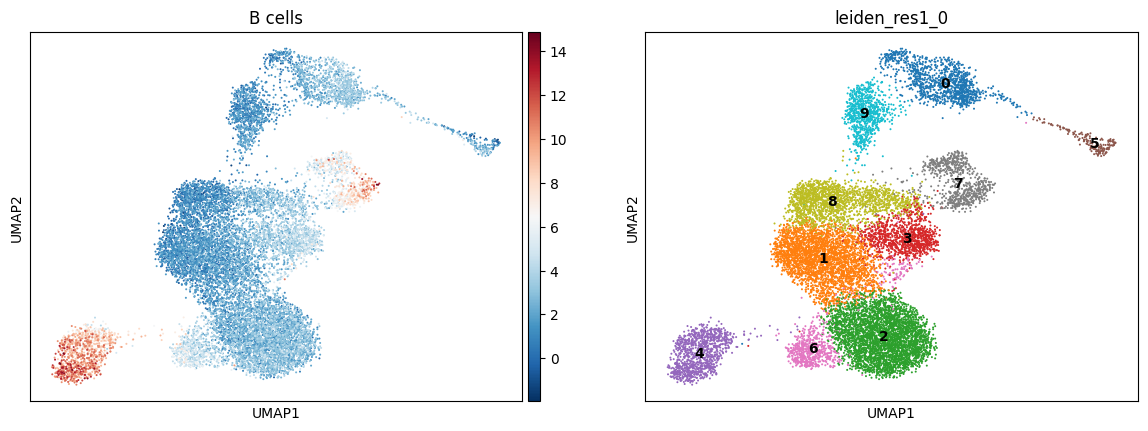

In [53]:
sc.pl.umap(score, color=["B cells", "leiden_res1_0"], cmap='RdBu_r', legend_loc="on data")

In [54]:
# Visualiuations

import seaborn as sns

2025-12-11 01:04:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-11 01:04:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-11 01:04:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-11 01:04:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-11 01:04:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

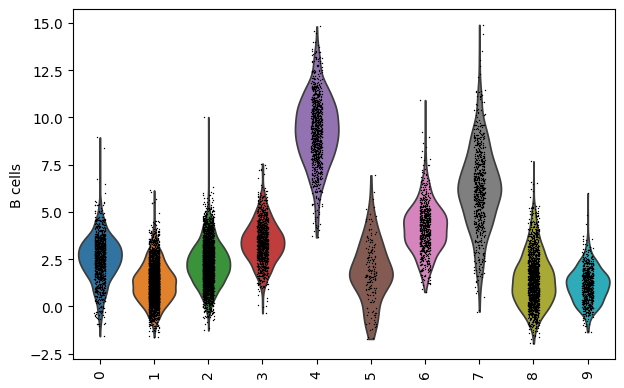

In [55]:
sc.pl.violin(score, keys=['B cells'], groupby='leiden_res1_0', rotation=90)

In [56]:
# Understanding what each cluster represents
# rank genes
bone_marrow_adata_rank = dc.tl.rankby_group(score, groupby="leiden_res1_0", reference="rest", method="t-test_overestim_var")
bone_marrow_adata_rank = bone_marrow_adata_rank[bone_marrow_adata_rank["stat"] > 0]
bone_marrow_adata_rank.head()

,group,reference,name,stat,meanchange,pval,padj
0,0,rest,Neutrophils,103.381768,6.208375,0.0,0.0
1,0,rest,Alveolar macrophages,100.066537,4.808218,0.0,0.0
2,0,rest,Monocytes,97.780354,9.793078,0.0,0.0
3,0,rest,Macrophages,85.672180,5.758709,0.0,0.0
4,0,rest,Kupffer cells,84.882860,3.559975,0.0,0.0


In [57]:
cluster_annotations = bone_marrow_adata_rank[bone_marrow_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()

C:\Users\User\AppData\Local\Temp\ipykernel_24984\243225156.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_annotations = bone_marrow_adata_rank[bone_marrow_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()


In [58]:
cluster_annotations

{'0': 'Neutrophils',
 '1': 'Gamma delta T cells',
 '2': 'T memory cells',
 '3': 'NK cells',
 '4': 'B cells memory',
 '5': 'Platelets',
 '6': 'T memory cells',
 '7': 'Plasma cells',
 '8': 'Gamma delta T cells',
 '9': 'Monocytes'}

In [59]:
bone_marrow_adata.obs['cell_type'] = bone_marrow_adata.obs['leiden_res1_0'].map(cluster_annotations) 

# Subsetting for multiple genes in the 'source' column
available_genes = set(bone_marrow_adata.var_names)

b_cell_markers = markers[markers['source'].isin(['B cells memory'])]['target']
b_cell_markers = b_cell_markers[b_cell_markers.isin(available_genes)]

nk_cell_markers = markers[markers['source'].isin(['Natural killer T cells'])]['target']
nk_cell_markers = nk_cell_markers[nk_cell_markers.isin(available_genes)]

t_cells_markers = markers[markers['source'].isin(['T cells'])]['target']
t_cells_markers = t_cells_markers[t_cells_markers.isin(available_genes)]

b_cell_markers

142     ENSG00000042980
331     ENSG00000163568
387     ENSG00000012779
719     ENSG00000112182
724     ENSG00000153064
789     ENSG00000136573
1164    ENSG00000112486
1200    ENSG00000134061
1203    ENSG00000177455
1211    ENSG00000158481
1232    ENSG00000012124
1256    ENSG00000139193
1292    ENSG00000104894
1294    ENSG00000004468
1380    ENSG00000110848
1391    ENSG00000137101
1399    ENSG00000105369
1405    ENSG00000007312
1409    ENSG00000121594
1419    ENSG00000066294
1425    ENSG00000114013
1928    ENSG00000117322
2140    ENSG00000160683
2293    ENSG00000170456
2850    ENSG00000072694
2869    ENSG00000132704
3355    ENSG00000176533
3412    ENSG00000125245
3636    ENSG00000152804
3734    ENSG00000241106
4068    ENSG00000211898
4090    ENSG00000211899
4099    ENSG00000211592
4231    ENSG00000104432
4298    ENSG00000140968
5061    ENSG00000227507
5107    ENSG00000112799
5406    ENSG00000156738
5877    ENSG00000196436
5965    ENSG00000135318
6190    ENSG00000083454
6292    ENSG0000

... storing 'cell_type' as categorical


categories: B cells memory, Gamma delta T cells, Monocytes, etc.
var_group_labels: B cells, NK cells, T cells


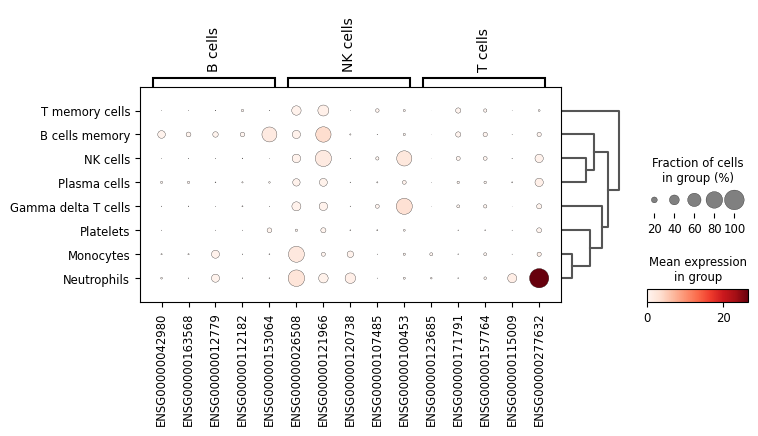

In [60]:
# Other methods of visualization
marker_genes_dict = {
    "B cells": b_cell_markers.head().tolist(),
    "NK cells": nk_cell_markers.head().tolist(),
    "T cells": t_cells_markers.head().tolist()
}

sc.pl.dotplot(bone_marrow_adata, marker_genes_dict, "cell_type", dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: B cells, NK cells, T cells


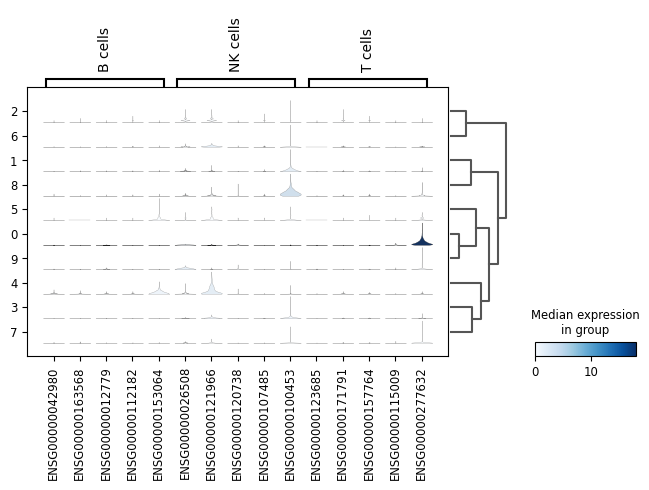

In [61]:
sc.pl.stacked_violin(
    bone_marrow_adata, marker_genes_dict, groupby="leiden_res1_0",  dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: B cells, NK cells, T cells


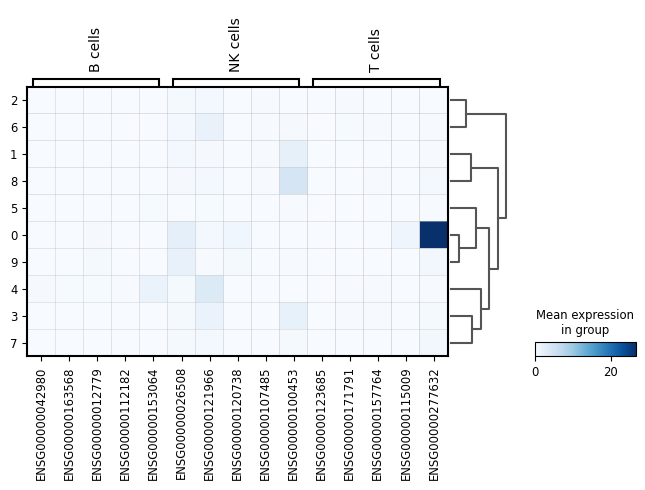

In [62]:
sc.pl.matrixplot(
    bone_marrow_adata,
    marker_genes_dict,
    "leiden_res1_0",
    dendrogram=True,
    cmap="Blues",
)

categories: 0, 1, 2, etc.
var_group_labels: B cells, NK cells, T cells


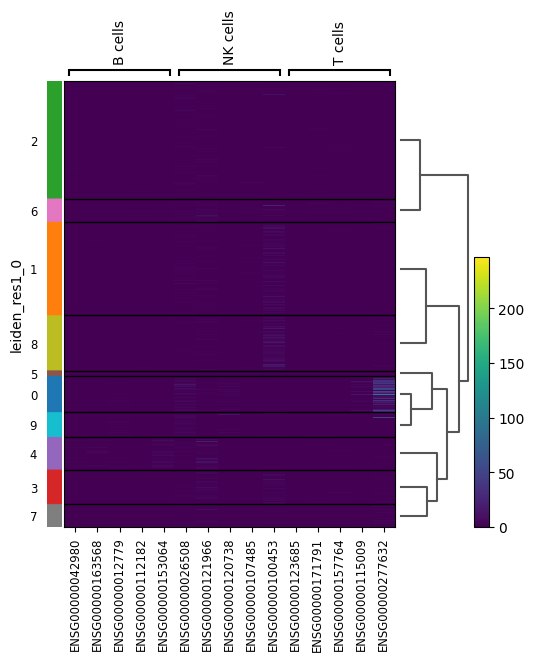

In [63]:
sc.pl.heatmap(
    bone_marrow_adata, marker_genes_dict, groupby="leiden_res1_0", cmap="viridis", dendrogram=True)

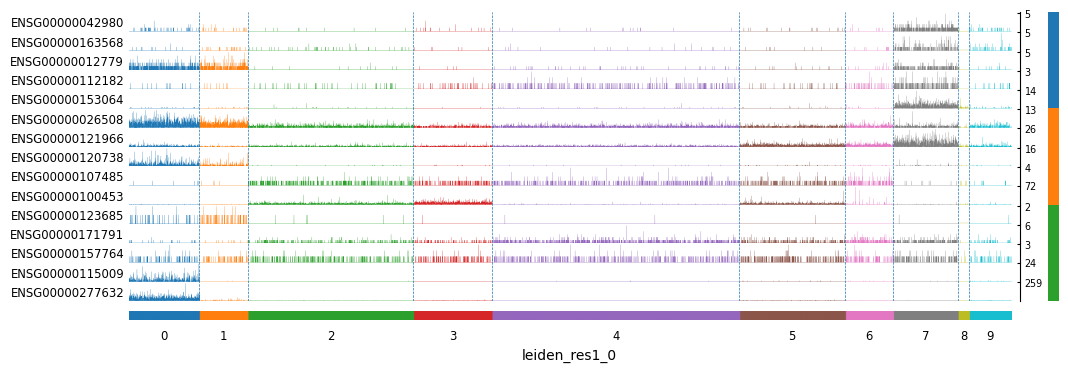

In [130]:
# title Using genome tracks
sc.pl.tracksplot(bone_marrow_adata, marker_genes_dict, groupby="leiden_res1_0", dendrogram=False)